# P5 - 01 - Exploratory Notebook
This notebook is the exploratory analysis of the **Brazilian E-Commerce Public Dataset by Olis** that can be
downloaded [on this Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce).

The goal of this project is to perform a **customer clustering** on the dataset, in order to provide multiple
customers categories to the sales team for their upcoming actions. We also want to evaluate the **clustering
lifespan** if order to give them a maintenance quotation for future clustering updates.

In [1]:
%load_ext autoreload

import datetime
import folium
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns

from dateutil import parser

import geopy.distance

from IPython.display import Image

from functions import *

In [2]:
sns.set_theme(style="whitegrid")

# 1. Loading and understanding the files
After downloading the datasete [on Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce) we obtain 9 CSV files.
 These files seem to be dump/extracts from a database as they contain some primary keys.

## 1.1 Loading all files

In [3]:
# Loading all files
data_customers = pd.read_csv('./data/customers.csv', sep=',', header=0)
data_sellers = pd.read_csv('./data/sellers.csv', sep=',', header=0)
data_orders = pd.read_csv('./data/orders.csv', sep=',', header = 0, parse_dates=[
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
])
data_order_items = pd.read_csv('./data/order_items.csv', sep=',', header=0)
data_order_payments = pd.read_csv('./data/order_payments.csv', sep=',', header=0)
data_order_reviews = pd.read_csv('./data/order_reviews.csv', sep=',', header=0, parse_dates=[
    'review_creation_date'
])
data_products = pd.read_csv('./data/products.csv', sep=',', header=0)
data_category_translations = pd.read_csv('./data/category_translations.csv', sep=',', header=0)
data_geolocations =  pd.read_csv('./data/geolocations.csv', sep=',', header=0)

# We set all data in a single dictionary to simplify future uses
datas = {
    'customers': data_customers,
    'sellers': data_sellers,
    'orders': data_orders,
    'order_items': data_order_items,
    'order_payments': data_order_payments,
    'order_reviews': data_order_reviews,
    'products': data_products,
    'category_translations': data_category_translations,
    'geolocations': data_geolocations
}

# We define colors for each file that we will use on the UML diagram and one this file
COLOR_CUSTOMER = '#cc7900'
COLOR_PRODUCTS = '#e95858'
COLOR_SELLER = '#1594e8'
COLOR_ORDERS = '#7fcac3'

In [4]:
# We merge the customer_unique_id to the order file for next analysis
data_orders = data_orders.merge(
    data_customers[['customer_id', 'customer_unique_id']],
    how='left',
    left_on='customer_id',
    right_on='customer_id'
)

## 1.2 Files sizes and connections
We can represent our files as an UML diagram in order to easily understand how files are linked.

In [5]:
# Files sizes
for name, data in datas.items():
    print(name + ' : ' + str(len(data)) + ' elements')

customers : 99441 elements
sellers : 3095 elements
orders : 99441 elements
order_items : 112650 elements
order_payments : 103886 elements
order_reviews : 99224 elements
products : 32951 elements
category_translations : 71 elements
geolocations : 1000163 elements


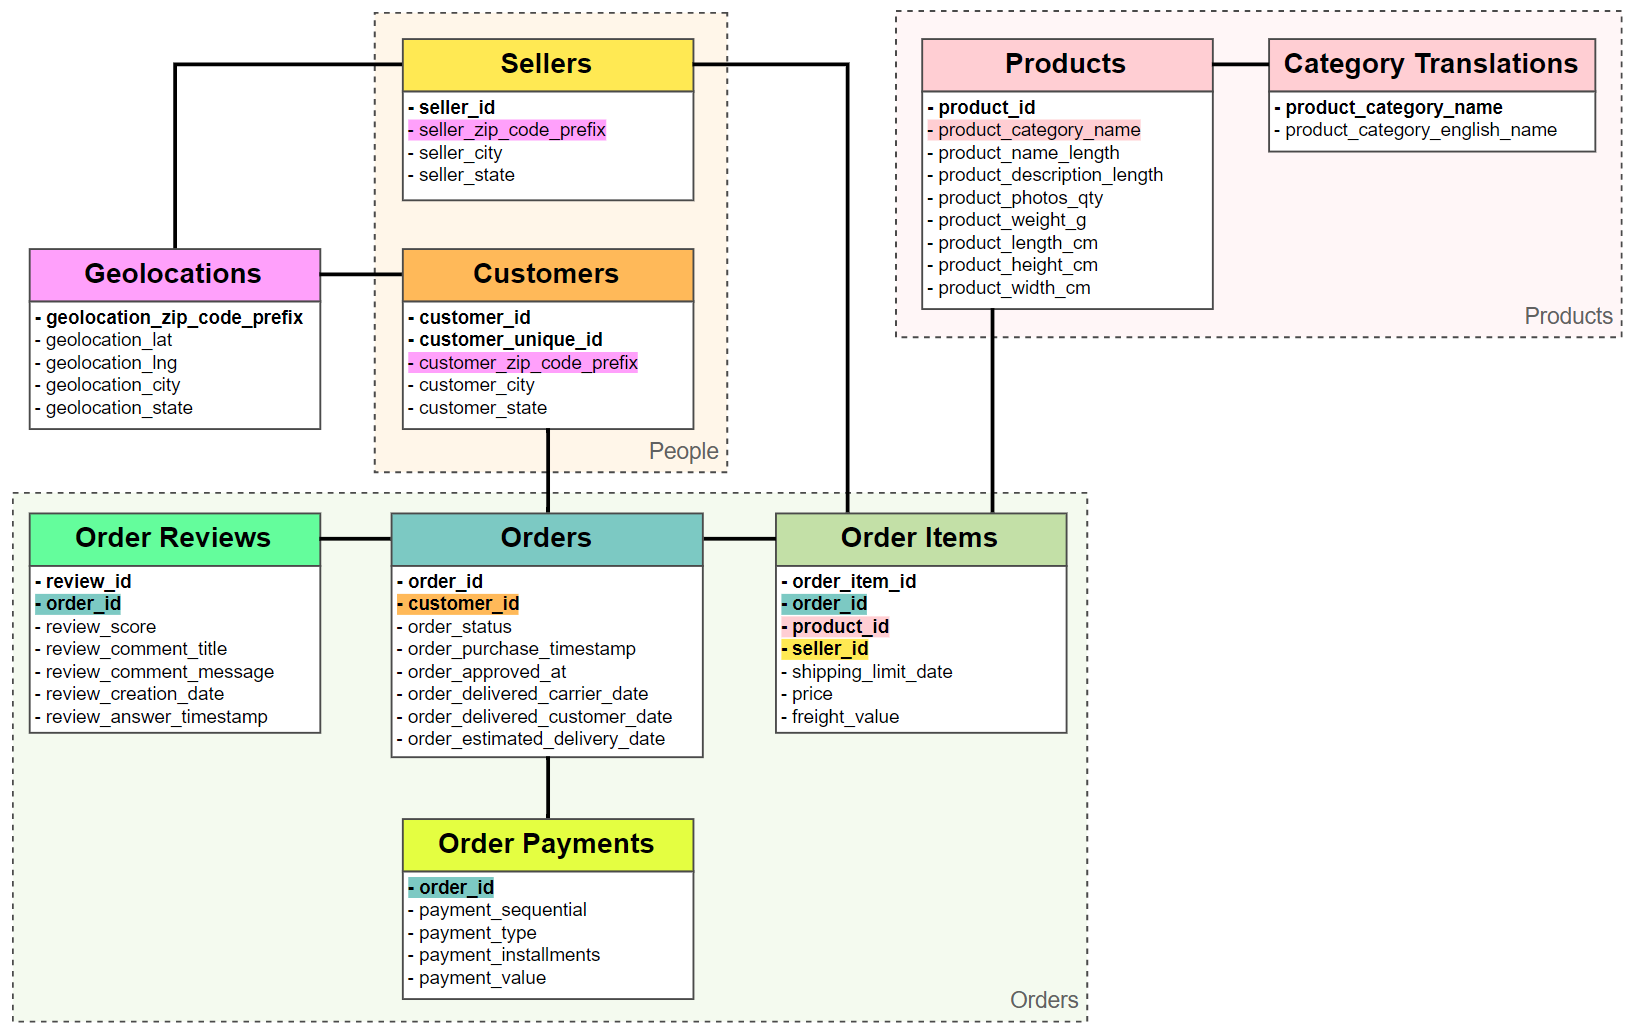

In [6]:
Image(filename='./Polist_02_Diagramme_UML.png', width=500)

In [7]:
data_test = data_orders.merge(
    data_order_items,
    how='left',
    left_on='order_id',
    right_on='order_id'
).merge(
    data_products,
    how='left',
    left_on='product_id',
    right_on='product_id'
)

data_test[['customer_id', 'product_category_name']].groupby('customer_id').agg(pd.Series.mode)

product_category_name
customer_id                                           
00012a2ce6f8dcda20d059ce98491703            brinquedos
000161a058600d5901f007fab4c27140          beleza_saude
0001fd6190edaaf884bcaf3d49edf079                 bebes
0002414f95344307404f0ace7a26f1d5            cool_stuff
000379cdec625522490c315e70c7a9fb       cama_mesa_banho
...                                                ...
fffecc9f79fd8c764f843e9951b11341       cama_mesa_banho
fffeda5b6d849fbd39689bb92087f431             telefonia
ffff42319e9b2d713724ae527742af25       cama_mesa_banho
ffffa3172527f765de70084a7e53aae8      moveis_decoracao
ffffe8b65bbe3087b653a978c870db99                    []

[99441 rows x 1 columns]

# 2. Analysing data

## 2.1 Products
Before exploring the products, let's **add the english category** name that is more comprehensible for us.

In [8]:
products = data_products.copy(deep=True)

### 2.1.1 Missing values
The chart bellow shows us that the product file is very well filled.

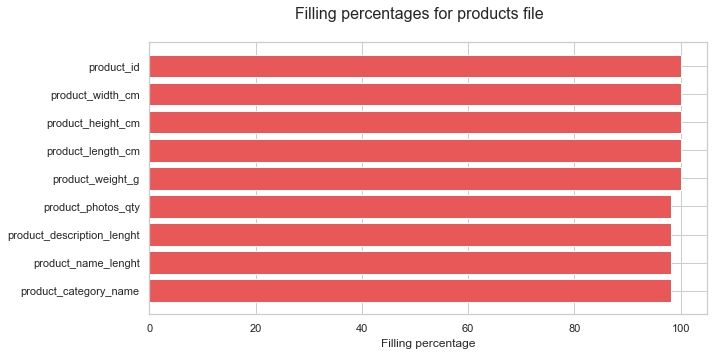

In [9]:
show_filling_percentages(products, color=COLOR_PRODUCTS)

### 2.1.2 Most used categories
The following chart displayed what are the most **used** categories (total number of products by category). This is
not the most **bought** product categories.

In [10]:
# Adding the english categories names to the initial products dataset
products = pd.merge(
    products,
    data_category_translations.set_index('product_category_name'),
    how="left",
    left_on='product_category_name',
    right_index=True
)

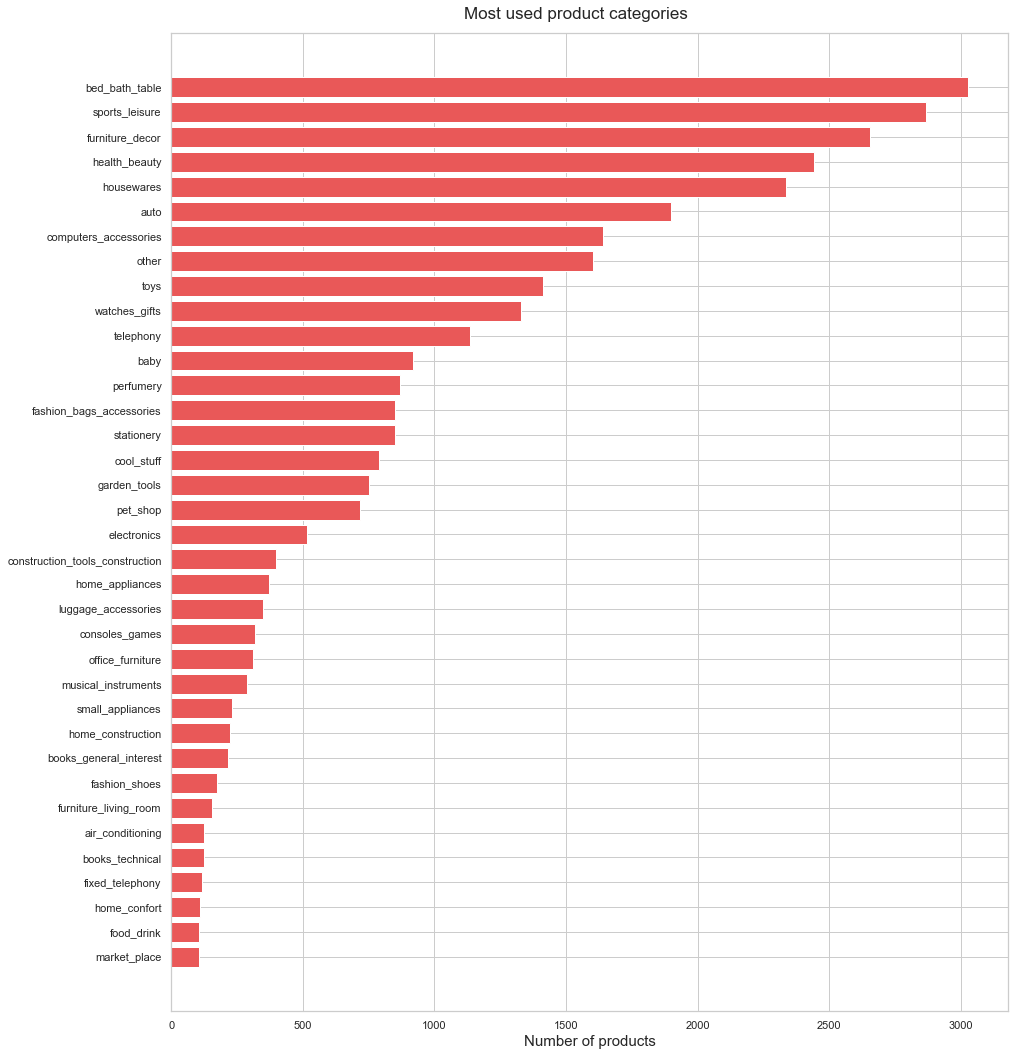

In [11]:
show_most_use_categories(
    products.copy(deep=True),
    column_name = 'product_category_name_english',
    threshold = 0.3,
    grouping_name = 'other',
    color = COLOR_PRODUCTS,
    title = "Most used product categories"
)

### 2.1.3 Boxplots

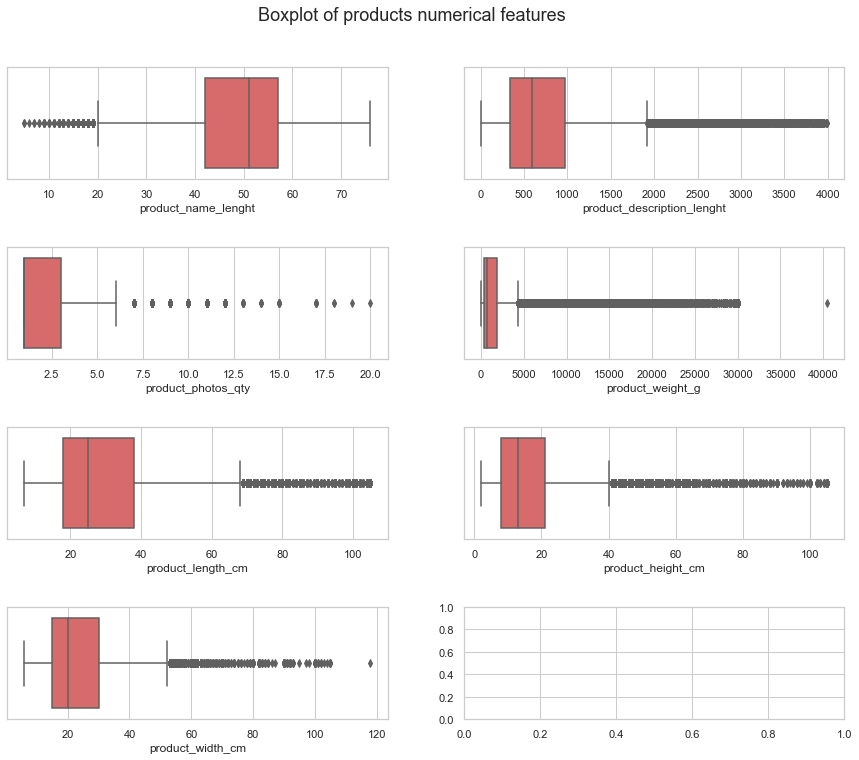

In [12]:
plot_all_possible_boxplots(
    products.copy(deep=True),
    color=COLOR_PRODUCTS,
    title="Boxplot of products numerical features"
)

## 2.2 Geolocations
Let's use the **Folium** library to plot our customers and sellers locations.

In [13]:
# As we only have code_prefix + city + state for customers and sellers
# we can drop duplicates based on these 3 features
unique_geolocations = data_geolocations.drop_duplicates(
    subset=['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state'],
    keep='first'
)

# Calculating mean lat/lng for each city name
cities_coordinates = unique_geolocations\
    .drop(columns=['geolocation_zip_code_prefix', 'geolocation_state'])\
    .groupby('geolocation_city')\
    .mean()

states_coordinates = data_geolocations[['geolocation_lat', 'geolocation_lng', 'geolocation_state']]\
    .groupby('geolocation_state')\
    .mean()

### 2.2.1 Customers geolocations
#### By city

In [14]:
display_geolocations_map(
    geolocated_data=data_customers,
    coordinates_data=cities_coordinates,
    join_column='customer_city',
    display_threshold=10,
    max_circle_size=200000,
    color=COLOR_CUSTOMER,
    initial_zoom=5,
    initial_center=[-22.947655830413595, -46.81768570574731]
)

#### By state

In [15]:
display_geolocations_map(
    geolocated_data=data_customers,
    coordinates_data=states_coordinates,
    join_column='customer_state',
    display_threshold=10,
    max_circle_size=400000,
    color=COLOR_CUSTOMER,
    initial_zoom=4,
    initial_center=[-14.897528781047848, -48.43491017205378]
)

### 2.2.2 Sellers geolocations
#### By city

In [16]:
display_geolocations_map(
    geolocated_data=data_sellers,
    coordinates_data=cities_coordinates,
    join_column='seller_city',
    display_threshold=10,
    max_circle_size=400000,
    color=COLOR_SELLER,
    initial_zoom=6,
    initial_center=[-23.042571237229165, -47.00395768257054]
)

#### By state

In [17]:
display_geolocations_map(
    geolocated_data=data_sellers,
    coordinates_data=states_coordinates,
    join_column='seller_state',
    display_threshold=10,
    max_circle_size=400000,
    color=COLOR_SELLER,
    initial_zoom=4,
    initial_center=[-14.897528781047848, -48.43491017205378]
)

### 2.2.3 Distance between customers and sellers

## 2.3 Orders

### 2.3.1 Orders sizes based on quantity and price

In [18]:
merge_order_items = pd.merge(
    data_orders,
    data_order_items,
    how='outer',
    left_on='order_id',
    right_on='order_id'
)

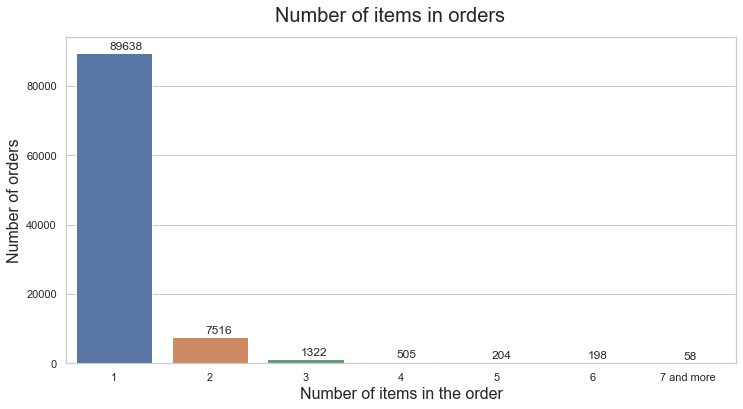

In [19]:
# We chain 2 value counts to obtains the number of items for each order
total_items_per_order = merge_order_items['order_id'].value_counts().to_frame()
total_items_per_order.loc[total_items_per_order['order_id'] >= 7, 'order_id'] = '7 and more'
total_items_per_order = total_items_per_order.value_counts().to_frame().reset_index().set_index('order_id')

# Plot 1 - With all order item
plt.figure(figsize=(12, 6))
sns.barplot(
    data=total_items_per_order,
    x=np.arange(len(total_items_per_order)),
    y=0,
    ax = plt.gca()
)

index = 0
for value in total_items_per_order[0]:
    plt.gca().annotate(value, xy=(index - 0.05, value + 1000))
    index += 1

plt.gca().set_xticklabels(total_items_per_order.index.values)
plt.suptitle('Number of items in orders', fontsize=20, y=0.95)
plt.gca().set_xlabel('Number of items in the order', fontsize=16)
plt.gca().set_ylabel('Number of orders', fontsize=16)

plt.show()

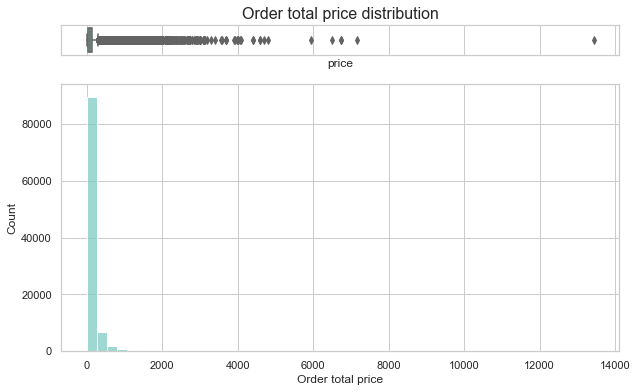

In [20]:
order_total_prices = merge_order_items[['order_id', 'price']]\
    .groupby('order_id')\
    .sum()

fig, axes = plt.subplots(
    figsize=(10, 6),
    nrows=2,
    sharex="col",
    gridspec_kw={"height_ratios": (.10, .90)}
)

axes[0].set_title("Order total price distribution", fontsize=16)
axes[0].set_xlabel("Order total price")
axes[1].set_xlabel("Order total price")
sns.boxplot(x=order_total_prices['price'], ax=axes[0], palette=[COLOR_ORDERS])
sns.histplot(order_total_prices['price'], bins=50, ax=axes[1], color=[COLOR_ORDERS])

plt.show()

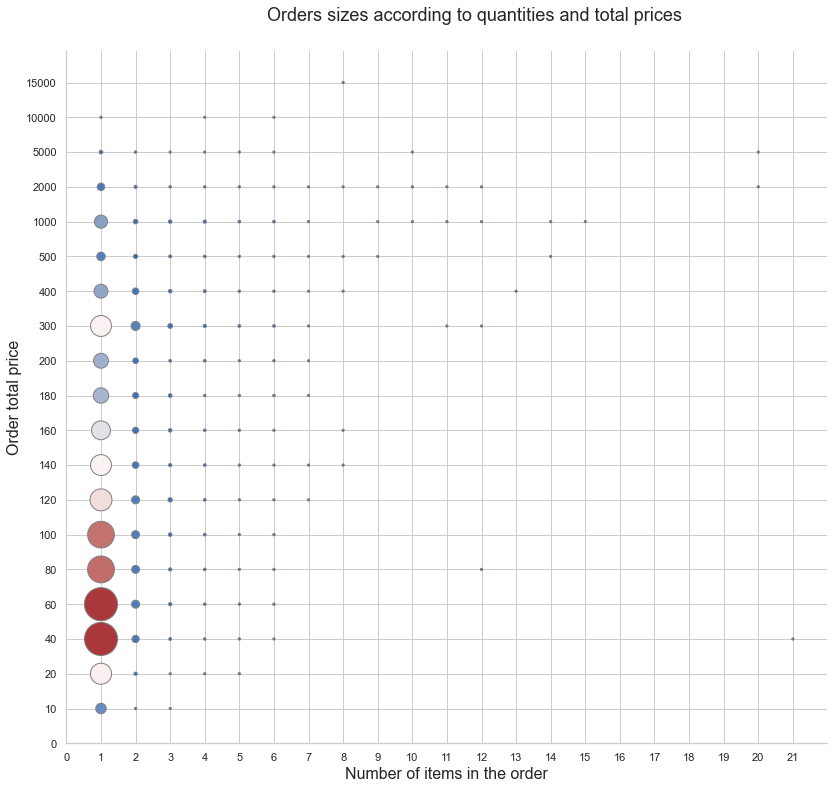

In [21]:
# Let's create a heatmap with both price and number of articles
heatmap_df = merge_order_items

# We add a column with only "1" to have the item quantity with a sum groupby
heatmap_df['quantity'] = 1
heatmap_df = heatmap_df[['order_id', 'price', 'quantity']].groupby('order_id').sum()

# We manually create price ranges for the heatmap using the number of different quantities
# in order to create a square heatmap
price_steps = [0, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 15000]

step_index = 0
last_step = 0
for price_step in price_steps:
    heatmap_df.loc[
        (heatmap_df['price'] >= last_step) & (heatmap_df['price'] < price_step),
        'price_fork'
    ] = step_index
    step_index += 1
    last_step = price_step

# Counting values for each combination of quantity / price
heatmap_df = heatmap_df.reset_index()
heatmap_df = heatmap_df[['quantity', 'price_fork']].value_counts().reset_index()
heatmap_df.rename(columns={0: 'total'}, inplace=True)


# Finally ploting the heatmap
plot = sns.relplot(
    data=heatmap_df,
    x='quantity',
    y='price_fork',
    size='total',
    hue='total',
    palette='vlag',
    edgecolor='grey',
    linewidth=1,
    hue_norm=(1, 11000),
    sizes=(5, 1100)
)
plot.fig.set_figheight(11)
plot.fig.set_figwidth(15)
plot.fig.suptitle("Orders sizes according to quantities and total prices", fontsize=18, y=1.02)
plot.fig.gca().set_xlabel("Number of items in the order", fontsize=16)
plot.fig.gca().set_ylabel("Order total price", fontsize=16)
plot.set(xticks=np.arange(heatmap_df['quantity'].max() + 1))
plot.set(yticks=np.arange(len(price_steps)))
plot.set(yticklabels=price_steps)
plot._legend.remove()

On this figure, we can notice that most of the orders contains only 1 item, and the average order
 total price is around 40-60 BRL.

### 2.3.2 Order shipments

In [22]:
data_orders_work = data_orders.copy(deep=True)
data_orders_work

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp   order_approved_at  \
0        delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   
...            ...                      ...                 ...   
99436    delivered      2017-03-09 09:54:05 2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58 2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43 2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27 2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30 2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date                customer_unique_id  
0                        2017-10-18  7c396fd4830fd04220f754e42b4e5bff  
1                        2018-08-13  af07308b275d755c9edb36a90c618231  
2                        2018-09-04  3a653a41f6f9fc3d2a113cf8398680e8  
3                        2017-12-15  7c142cf63193a1473d2e66489a9ae977  
4                        2018-02-26  72632f0f9dd73dfee390c9b22eb56dd6  
...                             ...                               ...  
99436                    2017-03-28  6359f309b166b0196dbf7ad2ac62bb5a  
99437                    2018-03-02  da62f9e57a76d978d02ab5362c509660  
99438                    2017-09-27  737520a9aad80b3fbbdad19b66b37b30  
99439                    2018-02-15  5097a5312c8b157bb7be58ae360ef43c  
99440                    2018-04-03  60350aa974b26ff12caad89e55993bd6  

[99441 rows x 9 columns]

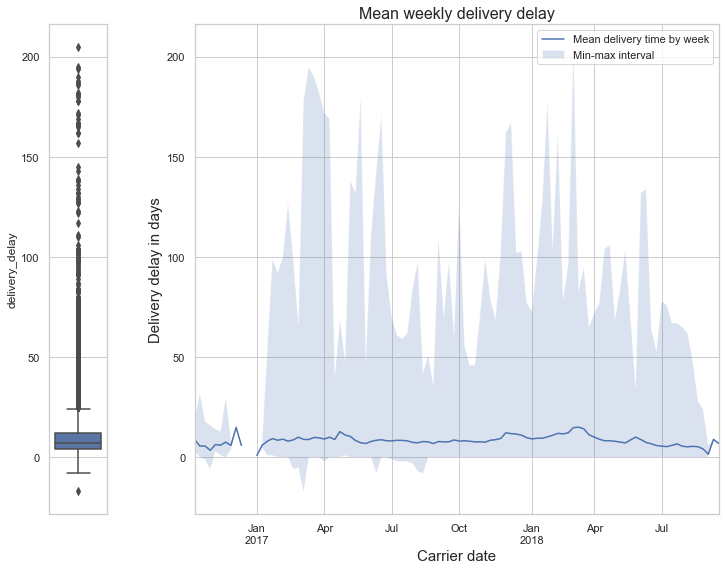

In [23]:
data_orders_work['delivery_delay'] = data_orders_work['order_delivered_customer_date'] - \
                                     data_orders_work['order_delivered_carrier_date']
data_orders_work['delivery_delay'] = data_orders_work['delivery_delay'].dt.days

# Lets plot the average delivery time evolution by week
delivery_delay = data_orders_work.copy().set_index('order_delivered_carrier_date')
delivery_delay = delivery_delay['delivery_delay'].resample('W').agg(['mean', 'min', 'max'])

fig, axes = plt.subplots(figsize=(12, 9), ncols=2, gridspec_kw={"width_ratios": (.10, .90)})
fig.subplots_adjust(wspace=0.3)

# Plotting the delivery delay boxplot
sns.boxplot(y=data_orders_work['delivery_delay'], ax=axes[0])

# Ploting the weekly mean delivery delay
delivery_delay['mean'].plot(label="Mean delivery time by week", ax=axes[1])
axes[1].set_title("Mean weekly delivery delay", fontsize=16)
axes[1].fill_between(
    delivery_delay.index,
    delivery_delay['min'],
    delivery_delay['max'],
    alpha=0.2,
    label="Min-max interval"
)
axes[1].set_xlabel('Carrier date', fontsize=15)
axes[1].set_ylabel('Delivery delay in days', fontsize=15)
axes[1].legend()

plt.show()

On this figure we can notice 2 things :
* The min/max interval is very large an can **reach 150 days** (almost 6 month !)
* Sometimes the delivery delay is negative, so we have some **invalid date**.

Let's try to understand where these long delays come from.

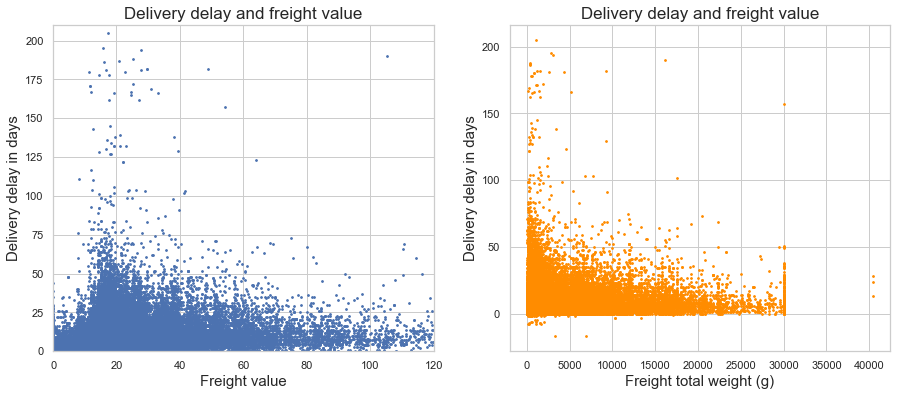

In [24]:
# Merging order values with freight and product values
delivery_analysis_data = data_orders_work\
    .merge(
        data_order_items[['order_id', 'freight_value', 'product_id']],
        how='left',
        left_on='order_id',
        right_on='order_id'
    ).merge(
        data_products[['product_id', 'product_weight_g']],
        how='left',
        left_on='product_id',
        right_on='product_id'
    )

delivery_analysis_data[['order_id', 'delivery_delay', 'freight_value', 'product_weight_g']]\
    .groupby('order_id')\
    .agg({'delivery_delay': 'mean', 'freight_value': 'sum', 'product_weight_g': 'sum'})

fig, axes = plt.subplots(figsize=(15, 6), ncols=2)

# Ploting relation between delivery delay and freight value
axes[0].set_xlabel('Freight value', fontsize=15)
axes[0].set_ylabel('Delivery delay in days', fontsize=15)
axes[0].set_xlim(0, 120)
axes[0].set_ylim(0, 210)
axes[0].set_title("Delivery delay and freight value", fontsize=17)
axes[0].scatter(
    x=delivery_analysis_data['freight_value'],
    y=delivery_analysis_data['delivery_delay'],
    s=3
)

# Ploting relation between delivery delay and order total weight
axes[1].set_xlabel('Freight total weight (g)', fontsize=15)
axes[1].set_ylabel('Delivery delay in days', fontsize=15)
axes[1].set_title("Delivery delay and freight value", fontsize=17)
axes[1].scatter(
    x=delivery_analysis_data['product_weight_g'],
    y=delivery_analysis_data['delivery_delay'],
    color='darkorange',
    s=3
)

In [25]:
# Now we are going to compare delivery delay and distance between customer and seller
# At first we join all necessary files to obtain customer and seller positions
distance_data = data_orders_work[['order_id', 'customer_id', 'delivery_delay']]\
    .merge(
        data_order_items[['order_id', 'seller_id']],
        how='left',
        left_on='order_id',
        right_on='order_id'
    ).merge(
        data_customers[['customer_id', 'customer_city']],
        how='left',
        left_on='customer_id',
        right_on='customer_id'
    ).merge(
        data_sellers[['seller_id', 'seller_city']],
        how='left',
        left_on='seller_id',
        right_on='seller_id'
    ).merge(
        cities_coordinates,
        how='inner',
        left_on='customer_city',
        right_index=True
    ).merge(
        cities_coordinates,
        how='inner',
        left_on='seller_city',
        right_index=True,
        suffixes=['_customer', '_seller']
    )

# Droping all lines missing one or more coordinates
coordinates_columns = [
    'geolocation_lat_customer',
    'geolocation_lng_customer',
    'geolocation_lat_seller',
    'geolocation_lng_seller'
]
distance_data.dropna(how='any', subset=coordinates_columns, inplace=True)

# Calculating the distance between customer and seller using Geopy library
for index, row in distance_data[coordinates_columns].iterrows():
    distance_data.loc[index, 'distance'] = geopy.distance.distance(
        (row['geolocation_lat_customer'], row['geolocation_lng_customer']),
        (row['geolocation_lat_seller'], row['geolocation_lng_seller'])
    ).km

Text(0, 0.5, 'Deliveray delay (days)')

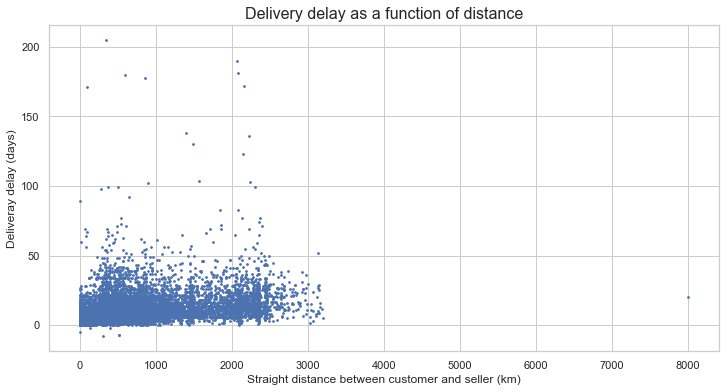

In [26]:
plt.figure(figsize=(12, 6))
data_sample = distance_data.sample(20000)
plt.scatter(
    x=data_sample['distance'],
    y=data_sample['delivery_delay'],
    s=3
)
plt.title('Delivery delay as a function of distance', fontsize=16)
plt.xlabel('Straight distance between customer and seller (km)')
plt.ylabel('Deliveray delay (days)')

### 2.3.3 Orders reviews

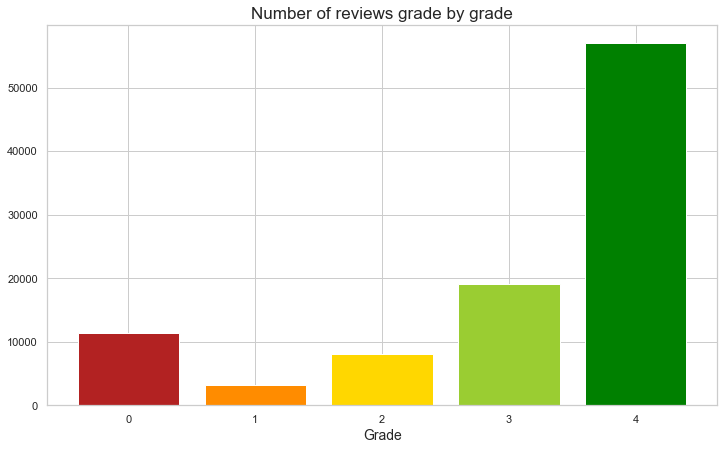

In [27]:
# Counting reviews by grade
reviews_count = data_order_reviews[['order_id', 'review_score']]\
    .drop_duplicates(subset=['order_id'])\
    .filter(['review_score'], axis='columns')\
    .value_counts()\
    .sort_index()

plt.figure(figsize=(12, 7))
plt.title("Number of reviews grade by grade", fontsize=17)
plt.xlabel("Grade", fontsize=14)
plt.bar(
    x=np.arange(len(reviews_count)),
    height=reviews_count,
    color=['firebrick', 'darkorange', 'gold', 'yellowgreen', 'green']
)
plt.show()

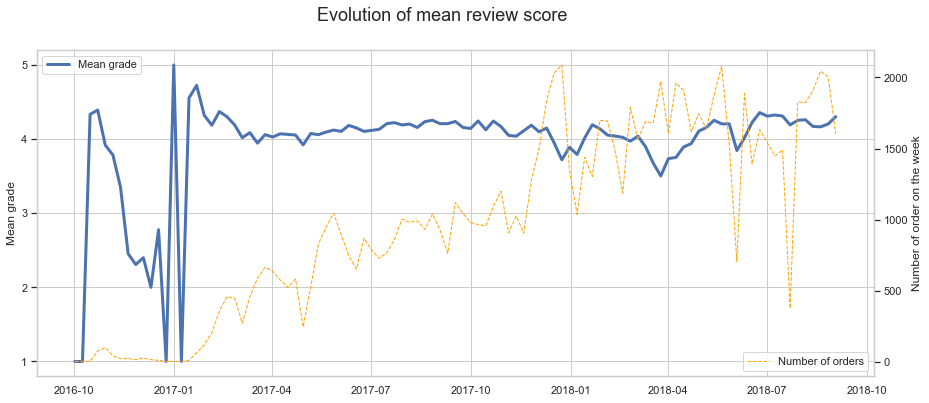

In [28]:
# Let's see the evolution of mean grade
order_reviews_evolution = data_order_reviews.set_index('review_creation_date')
order_reviews_evolution = order_reviews_evolution['review_score'].resample('W').agg(['mean',
                                                                                     'count'])

# Ploting evolution of mean review grade
fig, ax1 = plt.subplots(figsize=(15, 6))
fig.suptitle("Evolution of mean review score", fontsize=18)

ax1.set_yticks([1, 2, 3, 4, 5])
ax1.set_ylabel("Mean grade")
ax1.plot(order_reviews_evolution['mean'], linewidth=3, label="Mean grade")

ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Number of order on the week')
ax2.plot(
    order_reviews_evolution['count'],
    color="orange",
    linestyle="--",
    linewidth=1,
    label="Number of orders"
)

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.show()

## 2.4 Sellers

## 2.5 Customers

### 2.5.1 Customer ID versus Customer Unique ID

In [29]:
print("Number of ID : " + str(len(data_customers['customer_id'].unique())))
print("Number of UNIQUE ID : " + str(len(data_customers['customer_unique_id'].unique())))

Number of ID : 99441
Number of UNIQUE ID : 96096


In [30]:
print("Number of customer ID by customer unique ID")
data_customers[['customer_id', 'customer_unique_id']]\
    .groupby('customer_unique_id')\
    .count()\
    .sort_values(by='customer_id', ascending=False)\
    .value_counts()

Number of customer ID by customer unique ID


customer_id
1              93099
2               2745
3                203
4                 30
5                  8
6                  6
7                  3
9                  1
17                 1
dtype: int64

### 2.5.2 Number of order and price per customer
As shown with the pie chart below, all our database customer have ordered only once on the platform.

Mean order total price = 141.43818369143034
Median order total price = 89.0


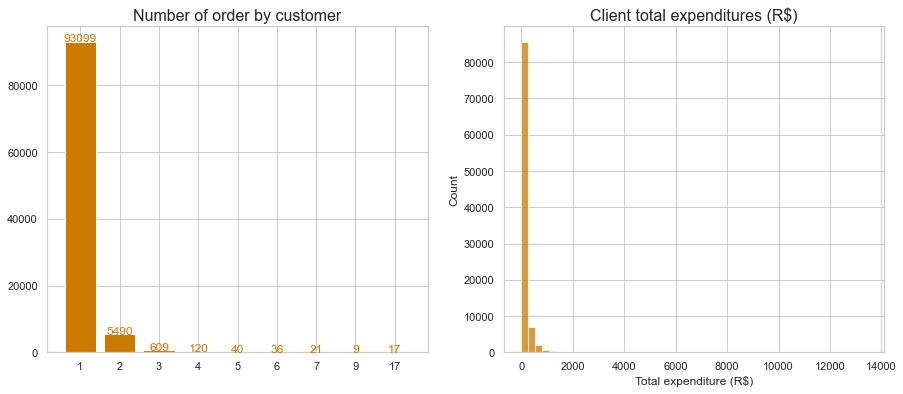

In [31]:
fig, axes = plt.subplots(figsize=(15, 6), ncols=2)

# Displaying a barchart with the number of order per customer
orders_customers_id_counts = data_orders['customer_unique_id'].value_counts().to_frame()
orders_customers_id_counts.columns = ['total_count']
customer_orders_count = data_customers[['customer_unique_id']].merge(
    orders_customers_id_counts,
    how='left',
    left_on='customer_unique_id',
    right_index=True
)
customer_orders_vc = customer_orders_count['total_count'].value_counts().sort_index()
axes[0].bar(
    x=np.arange(len(customer_orders_vc)),
    height=customer_orders_vc,
    color=COLOR_CUSTOMER
)
axes[0].set_title('Number of order by customer', fontsize=16)
axes[0].set_xticks(np.arange(len(customer_orders_vc)))
axes[0].set_xticklabels(customer_orders_vc.index)

i = 0
for index, value in customer_orders_vc.to_frame().iterrows():
    axes[0].annotate(
        value['total_count'],
        (i, value['total_count']),
        ha='center',
        color=COLOR_CUSTOMER
    )
    i += 1


# As we have on order per customer, we can re-use the total ordre price distribution
# we already calculated above
client_order_amounts = merge_order_items[['customer_unique_id', 'price']]
client_order_amounts = client_order_amounts.groupby('customer_unique_id').sum()

axes[1].set_title("Client total expenditures (R$)", fontsize=16)
axes[1].set_xlabel("Total expenditure (R$)")
sns.histplot(client_order_amounts['price'], bins=50, ax=axes[1], color=[COLOR_CUSTOMER])

# Also printing mean and median total prices
print("Mean order total price = " + str(client_order_amounts['price'].mean()))
print("Median order total price = " + str(client_order_amounts['price'].median()))

plt.show()

### 2.5.3 Type of payments
The number of payment for each order will show us how customer manage their payments and their
money.

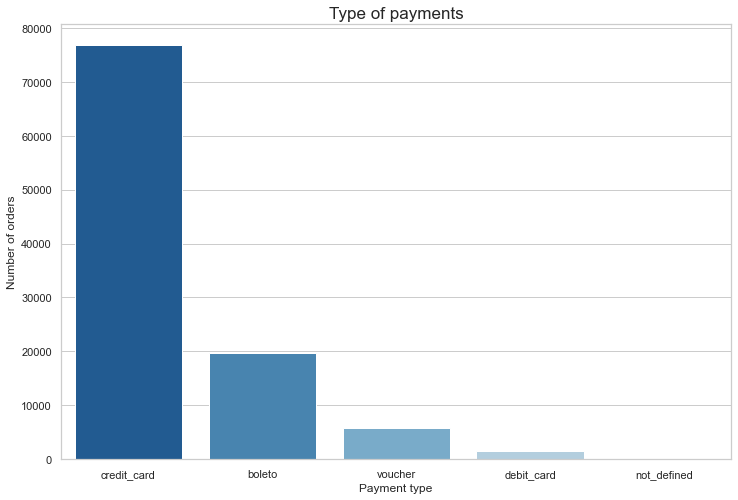

In [32]:
payments_data = data_order_payments[['order_id', 'payment_sequential', 'payment_type']]\
    .drop_duplicates(subset=['order_id', 'payment_sequential'])\
    .filter(['payment_type'], axis='columns')\
    .value_counts()\
    .to_frame()\
    .reset_index()\
    .set_index('payment_type')

plt.figure(figsize=(12, 8))
plt.title("Type of payments", fontsize=17)
sns.barplot(data=payments_data, x=payments_data.index, y=0, palette='Blues_r')
plt.gca().set_xlabel("Payment type")
plt.gca().set_ylabel("Number of orders")
plt.show()

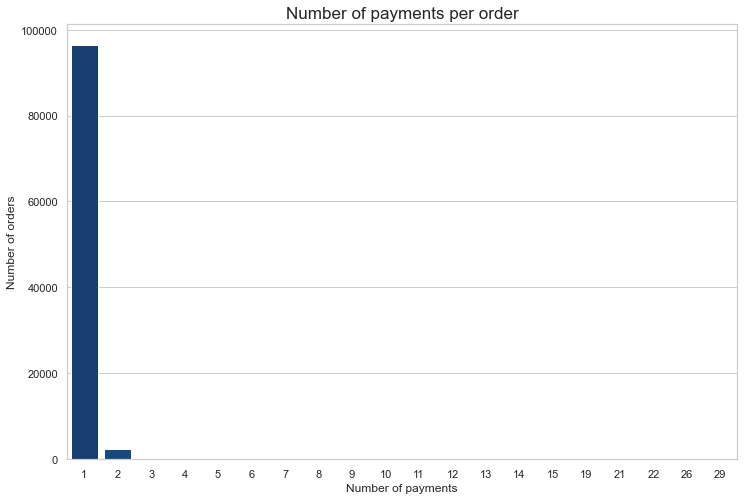

In [33]:
# Now let's see how many payments are done for each order
payments_data = data_order_payments[['order_id', 'payment_sequential']]\
    .drop_duplicates()\
    .groupby('order_id')\
    .max()\
    .value_counts()\
    .to_frame()\
    .reset_index()\
    .set_index('payment_sequential')\
    .sort_index()

plt.figure(figsize=(12, 8))
plt.title("Number of payments per order", fontsize=17)
sns.barplot(data=payments_data, x=payments_data.index, y=0, palette='Blues_r')
plt.gca().set_xlabel("Number of payments")
plt.gca().set_ylabel("Number of orders")
plt.show()

# 3. Creating an enriched customer dataset
The goal of this part is to create and export an enriched customer dataset for the modelisation
work we are going to do in the next Notebook.

Our export will take 2 parameters : a **start date** and an **end date** which will be used to
filter orders to take to calculate all customer values

Here are the features we are going to add to our dataset :
* The first order date on the given date range
* The last order date on the given date range
* The total number of orders on the date range
* The mean customer review grade on the given date range
* The number of reviews created by the customer on the given date range
* The mean number of payments per order per customer

In [35]:
# The function is defined into the functions.py file
# Reloading the data orders file to have the non-enriched one
create_enriched_customer_dataset(
    data_folder_path='./data/',
    start=datetime(2018, 1, 1),
    end=None
)

customer_id                customer_unique_id  \
0      06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1      18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2      4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3      b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4      4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   
...                                 ...                               ...   
99436  17ddf5dd5d51696bb3d7c6291687be6f  1a29b476fee25c95fbafc67c5ac95cf8   
99437  e7b71a9017aa05c9a7fd292d714858e8  d52a67c98be1cf6a5c84435bd38d095d   
99438  5e28dfe12db7fb50a4b2f691faecea5e  e9f50caf99f032f0bf3c55141f019d99   
99439  56b18e2166679b8a959d72dd06da27f9  73c2643a0a458b49f58cea58833b192e   
99440  274fa6071e5e17fe303b9748641082c8  84732c5050c01db9b23e19ba39899398   

       customer_zip_code_prefix          customer_city customer_state  \
0                         14409                 franca             SP   
1                          9790  sao bernardo do campo             SP   
2                          1151              sao paulo             SP   
3                          8775        mogi das cruzes             SP   
4                         13056               campinas             SP   
...                         ...                    ...            ...   
99436                      3937              sao paulo             SP   
99437                      6764        taboao da serra             SP   
99438                     60115              fortaleza             CE   
99439                     92120                 canoas             RS   
99440                      6703                  cotia             SP   

         first_order_date     last_order_date  total_orders  \
0                     NaT                 NaT           NaN   
1     2018-01-12 20:48:24 2018-01-12 20:48:24           1.0   
2     2018-05-19 16:07:45 2018-05-19 16:07:45           1.0   
3     2018-03-13 16:06:38 2018-03-13 16:06:38           1.0   
4     2018-07-29 09:51:30 2018-07-29 09:51:30           1.0   
...                   ...                 ...           ...   
99436 2018-04-07 15:48:17 2018-04-07 15:48:17           1.0   
99437 2018-04-04 08:20:22 2018-04-04 08:20:22           1.0   
99438 2018-04-08 20:11:50 2018-04-08 20:11:50           1.0   
99439                 NaT                 NaT           NaN   
99440                 NaT                 NaT           NaN   

       total_spent_amount  min_spent_amount  max_spent_amount  \
0                     NaN               NaN               NaN   
1                  289.00            289.00            289.00   
2                  139.94            139.94            139.94   
3                  149.94            149.94            149.94   
4                  230.00            230.00            230.00   
...                   ...               ...               ...   
99436               74.90             74.90             74.90   
99437              114.90            114.90            114.90   
99438               37.00             37.00             37.00   
99439                 NaN               NaN               NaN   
99440                 NaN               NaN               NaN   

       mean_review_score  min_review_score  total_reviews  \
0                    NaN               NaN            NaN   
1                    5.0               5.0            1.0   
2                    5.0               5.0            1.0   
3                    5.0               5.0            1.0   
4                    5.0               5.0            1.0   
...                  ...               ...            ...   
99436                4.0               4.0            1.0   
99437                5.0               5.0            1.0   
99438                1.0               1.0            1.0   
99439                NaN               NaN            NaN   
99440            